# Face Detection and Emotion Recognition

In this notebook, we have imported the models that we have trained on two datasets, FER-13 and Extended Cohn-Kanade (CK+). After that we define the functions for face detection using OpenCV.This function is used within a pipeline together with another function for predicting the emotion on the detected faces. The output of this pipeline is the input image with detected faces, marked with rectangles and labeled with the emotion class and probability of the model. Furthermore we have defined another function for real-time video which detects face from the camera and predicts its emotion.

In [ ]:
# pip install opencv-python
# !pip install tensorflow

In [ ]:
# %matplotlib auto

We are importing the necessary libraries and load the models that will be used for predictions. In order to load the models in this notebook they have to be in the proper folder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import models

In [49]:
model_fer=keras.models.load_model('emotion_modelh5.h5')
model_ck=keras.models.load_model('best_model_data_da.pt')
model=keras.models.load_model('fer_model')

Defining functions and pipeline

In [3]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def face_detection(image):
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))
    arr_img = []
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_LINEAR_EXACT)
        img = np.expand_dims(roi_gray, axis=-1)
        img = img.reshape(1,48,48,1)
        arr_img.append(img)

    return faces,arr_img

In [28]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def face_detection_with_chart_(image):
      
    arr_img=[]
    face_list=[]
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))

    

    for (x, y, w, h) in faces:
        roi_gray = image[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_LINEAR_EXACT)
        img = np.expand_dims(roi_gray, axis=-1)
        img = img.reshape(1,48,48,1)
        arr_img.append(img)
        face_list.append(roi_gray)


    return faces,arr_img,face_list

In [5]:
def get_prediction(image,model):
    
    emotion_label = np.array(['anger','disgust','fear', 'happy', 'sad', 'surprise','neutral'])
    image_scaled = image.astype('float32')/255.0
    
    
    prediction = model.predict(image_scaled)
    predict_class = np.argmax(prediction)
    predict_proba = np.round(np.max(prediction),2)
    emotion = emotion_label[predict_class]
    
    df=pd.DataFrame(prediction).T.set_index(emotion_label).rename({0: 'probability'}, axis='columns')
    
    return emotion,predict_proba,df

In [16]:
def get_color(prob):
    if prob > 0.5:
        color = (50, 205 , 0)
    else:
        color = (255, 0 , 0)
    
    return color

In [29]:
def pipeline_with_chart_(image,model):
    
    faces, imgs, face_list= face_detection_with_chart_(image)
    dfs=[]

    for img, (x, y, w, h) in zip(imgs,faces):
        emotion, probability, df = get_prediction(img,model)
        color = get_color(probability)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        thickness = 2
        dfs.append(df)
        image = cv2.putText(image, str(emotion)+':'+str(probability), (x,y), font, fontScale, color, thickness)
        
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()
    
    fig=plt.figure(figsize=(10,25))
    a=len(dfs)
    b=2
    i=1
    y_pos=np.arange(len(df.index.values))
    for idx, (df,face) in enumerate(zip(dfs,face_list)):
        
        plt.subplot(a, b, i)
        plt.title('Face :'+ str(idx+1))
        plt.imshow(face, cmap='gray')
        i = i + 1

        plt.subplot(a, b, i)
        plt.bar(y_pos,df['probability'])
        plt.xticks(y_pos,df.index.values)
        plt.ylabel('prob percentage')
        plt.xlabel('emotion')
        plt.title('Emotion probability distribution')
        i = i + 1



In [22]:
def pipeline_video(image,model):
    faces, imgs = face_detection(image)
    
    for img, (x, y, w, h) in zip(imgs,faces):
        emotion, probability, _ = get_prediction(img,model)
        color= get_color(probability)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        thickness = 2

        image = cv2.putText(image, str(emotion)+':'+str(probability), (x,y), font, fontScale, color, thickness)

    return image

Function outputs

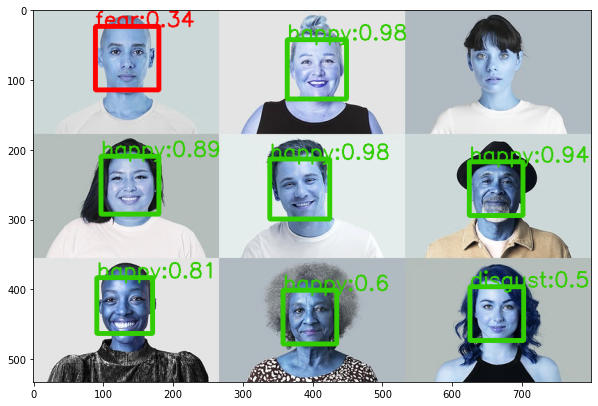

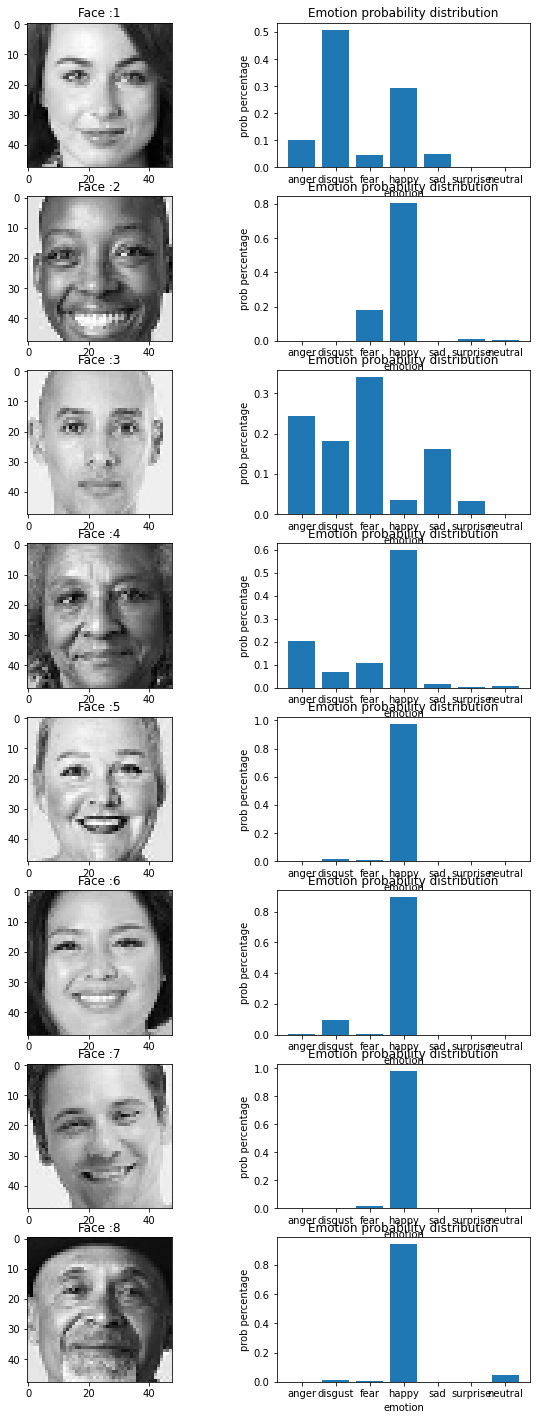

In [44]:
img=cv2.imread('image1.jpg')
# sliki\img1.jpg
pipeline_with_chart_(img,model_ck)

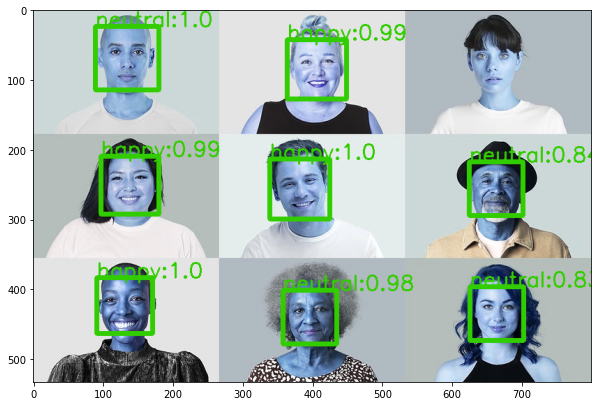

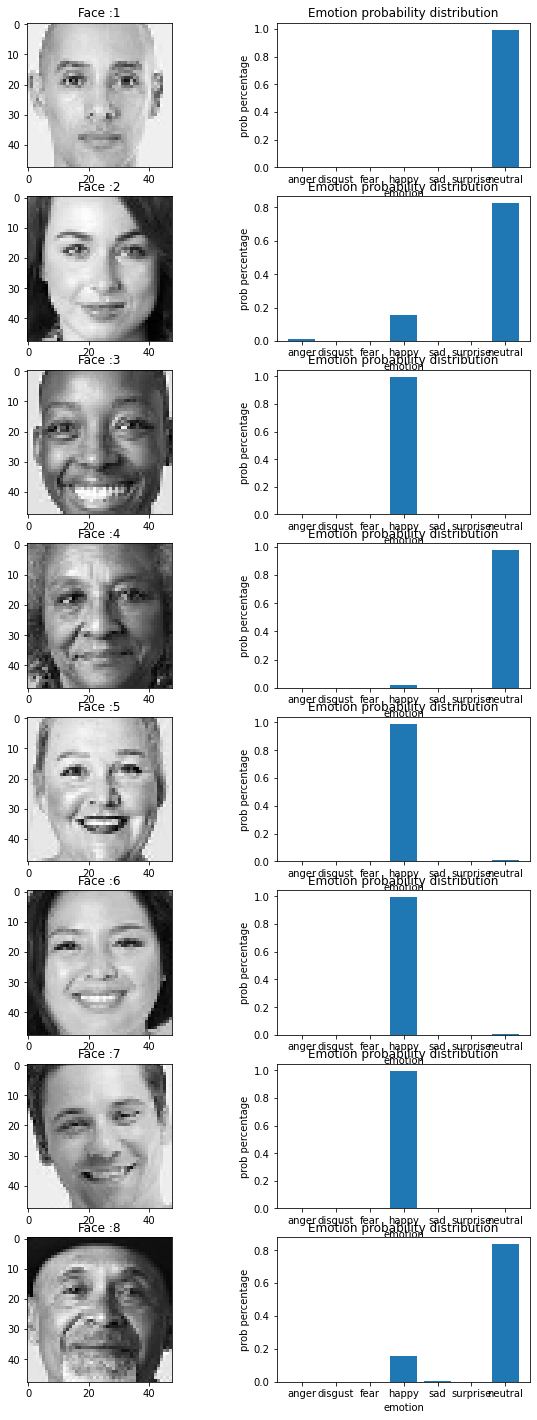

In [46]:
img=cv2.imread('image1.jpg')
# sliki\img1.jpg
pipeline_with_chart_(img,model)

Model: "fer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0 

In [51]:

def video_capture(model):

    cap=cv2.VideoCapture(0) 
    while True:
            ret, frame=cap.read() 
            # if a frame was succesfully grabbed
            if ret:
                    # display the frame in a window called frame
                    frame = pipeline_video(frame,model)
                    cv2.imshow('frame', frame)
                    cv2.waitKey(1)

            if cv2.waitKey(1) & 0xFF == ord('a'):
                break

    cap.release()
    cv2.destroyAllWindows()
